<a href="https://colab.research.google.com/github/ashimakeshava/NMA_marmots/blob/master/BehavData%26DDM_Paula.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install hddm


In [3]:
#@title Data retrieval
import os, requests
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib import rcParams 
import seaborn as sns
import glob
import pickle
from google.colab import drive

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
#@title Data loading


alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[11]
print(dat.keys())



dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


# Creating behavioral data DF

alldat contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each dat = alldat[k], you have the following fields:


*   dat['mouse_name']: mouse name
*   dat['date_exp']: when a session was performed
*   dat['spks']: neurons by trials by time bins.
*   dat['brain_area']: brain area for each neuron recorded.
*   dat['contrast_right']: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
*   dat['contrast_left']: contrast level for left stimulus.
*   dat['gocue']: when the go cue sound was played.
*   dat['response_times']: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.
*   dat['response']: which side the response was (-1, 0, 1). When the right-side stimulus had higher contrast, the correct choice was -1. 0 is a no go response.
*   dat['feedback_time']: when feedback was provided.
*   dat['feedback_type']: if the feedback was positive (+1, reward) or negative (-1, white noise burst).
*   dat['wheel']: exact position of the wheel that the mice uses to make a response, binned at 10ms.
*   dat['pupil']: pupil area (noisy, because pupil is very small) + pupil horizontal and vertical position.
*   dat['lfp']: recording of the local field potential in each brain area from this experiment, binned at 10ms.
*   dat['brain_area_lfp']: brain area names for the LFP channels.
*   dat['trough_to_peak']: measures the width of the action potential waveform for each neuron. Widths <=10 samples are "putative fast spiking neurons".
*   dat['waveform_w']: temporal components of spike waveforms. w@u reconstructs the time by channels action potential shape.
*   dat['waveform_u]: spatial components of spike waveforms.
*   dat['%X%_passive']: same as above for X = {spks, lfp, pupil, wheel, contrast_left, contrast_right} but for passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses.

So the variables we need for the behavioral analysis are:
'mouse_name', 'date_exp', 'contrast_right', 'contrast_left', 'gocue', 'response_time','response', 'feedback_time', 'feedback_type'


gocue, response_time, feedback_time are all arrays of arrays (an array of 1 cell arrays) and refuse to be tranformed to a df straightforwardly, so we're going to convert them in this really stupid ghetto way, then add them back. Sorry for anyone looking at this.

In [6]:

behav_dat = pd.DataFrame()
cum_trial_num=0

for k in range(len(alldat)):
  temp=alldat[k]
  t1=temp['response_time']
  t2=temp['gocue']
  t3=temp['feedback_time']

  response_time, gocue, feedback_time=np.zeros(len(t1)),np.zeros(len(t2)),np.zeros(len(t3))
  #fb=np.zeros(len(t4))
  trial, session=np.zeros(len(t1)),np.zeros(len(t1))
  prev_rew, avg_rew_hist_3, avg_rew_hist_full=np.zeros(len(t2)),np.zeros(len(t1)),np.zeros(len(t1))
  cum_trial_num=cum_trial_num+len(t1)

  for i in range(0,len(t1)):
    response_time[i]=t1[i][0]
    gocue[i]=t2[i][0]
    feedback_time=t3[i][0]
    trial[i]=i
    session[i]=k
    if (i==0):
      prev_rew[i]=0
    else:
      if (temp['feedback_type'][i-1]==1):
        prev_rew[i]=1
      else:
        prev_rew[i]=0
    i+=1

  window_size=3
  for q in range(window_size,len(prev_rew)):
    this_window = temp['feedback_type'][q- window_size : q]
    this_window[this_window <0] = 0
    window_average =np.mean(this_window)
    avg_rew_hist_3[q]=window_average
    q += 1

  for q in range(1,len(prev_rew)):
    this_window = temp['feedback_type'][0: q]
    window_average = np.mean(this_window)
    avg_rew_hist_full[q]=window_average
    q += 1 


  your_keys=['mouse_name', 'date_exp', 'contrast_right', 'contrast_left',  'response', 'response_time', 'feedback_type']
  sess_behav = { your_key: temp[your_key] for your_key in your_keys }
  sess_behav["response_time"]= response_time 
  sess_behav["gocue"]=gocue
  sess_behav["feedback_time"]=feedback_time
  sess_behav["trial_num"]=trial
  sess_behav["session"]=session
  sess_behav["prev_reward"]=prev_rew
  sess_behav["rew_hist_3"]=avg_rew_hist_3
  sess_behav["rew_hist_full"]=avg_rew_hist_full

  sess_behav_long =pd.DataFrame.from_dict(sess_behav)
  
  if k==0:
    behav_dat=sess_behav_long
  else:
    behav_dat=pd.concat([behav_dat, sess_behav_long], ignore_index=True)
  


behav_dat.head(20)

,mouse_name,date_exp,contrast_right,contrast_left,response,response_time,feedback_type,gocue,feedback_time,trial_num,session,prev_reward,rew_hist_3,rew_hist_full
0,Cori,2016-12-14,0.00,1.0,1.0,1.150204,1.0,1.027216,1.474423,0.0,0.0,0.0,0.000000,0.000000
1,Cori,2016-12-14,0.50,0.0,-1.0,1.399503,1.0,0.874414,1.474423,1.0,0.0,1.0,0.000000,1.000000
2,Cori,2016-12-14,0.50,1.0,1.0,0.949291,1.0,0.825213,1.474423,2.0,0.0,1.0,0.000000,1.000000
3,Cori,2016-12-14,0.00,0.0,0.0,2.266802,1.0,0.761612,1.474423,3.0,0.0,1.0,1.000000,1.000000
4,Cori,2016-12-14,1.00,0.5,1.0,0.816776,0.0,0.662010,1.474423,4.0,0.0,1.0,1.000000,1.000000
5,Cori,2016-12-14,0.00,0.0,1.0,1.517107,0.0,1.186819,1.474423,5.0,0.0,0.0,0.666667,0.800000
6,Cori,2016-12-14,0.00,0.0,-1.0,1.133210,0.0,0.588009,1.474423,6.0,0.0,0.0,0.333333,0.666667
7,Cori,2016-12-14,0.00,0.0,-1.0,1.349831,0.0,0.606410,1.474423,7.0,0.0,0.0,0.000000,0.571429
8,Cori,2016-12-14,0.00,0.0,0.0,2.097125,1.0,0.591209,1.474423,8.0,0.0,0.0,0.000000,0.500000
9,Cori,2016-12-14,0.50,1.0,1.0,1.249668,1.0,1.071217,1.474423,9.0,0.0,1.0,0.333333,0.555556


# Creating trial variables



Awesome! Now we need to calculate the following variables:

*   Trial type (no-go, two image, one image, equal contrast)
  * no_go if contrast is 0 on both sides
  * one_image
  * two_image_unequal: two images presented and one higher than the other
  * two_image_equal: two images with equal contrast
*   Accuracy (correct=0, incorrect=1)
  * no_go trials are only correct if 0
  * two_image_equal trials are correct if -1 or 1
  * one_image and two_image_unequal trials are correct depending on the direction
* Difference in contrast stim
  * 0 if no go or same contrast level
  * Negative (<0) if right side has more contrast
  * Positive (>0) if left side has more contrast 

*  Feedback type corresponds with correctness (better than expected, as expected, worse than expected)






In [7]:
##creating trial type variable
def conditions(s):
    if (s['contrast_right']==0 and s['contrast_left']==0):
        return "no_go"
    elif (s['contrast_right']==0 and s['contrast_left']>0):
        return "one_image"
    elif (s['contrast_left']==0 and s['contrast_right']>0):
        return "one_image"
    elif (s['contrast_left']!=0 and s['contrast_right']!=0):
        if (s['contrast_left']==s['contrast_right']):
          return "two_image_equal"
        else:
          return "two_image_unequal"
    else:
      return "???"

behav_dat['trial_type'] = behav_dat.apply(conditions, axis=1)

behav_dat.head()

pd.crosstab(behav_dat['trial_type'], [behav_dat['contrast_right'], behav_dat['contrast_left']])

contrast_right     0.00                0.25       ... 0.50      1.00               
contrast_left      0.00 0.25 0.50 1.00 0.00 0.25  ... 0.50 1.00 0.00 0.25 0.50 1.00
trial_type                                        ...                              
no_go              2649    0    0    0    0    0  ...    0    0    0    0    0    0
one_image             0  323  737  944  348    0  ...    0    0  945    0    0    0
two_image_equal       0    0    0    0    0  225  ...  226    0    0    0    0  221
two_image_unequal     0    0    0    0    0    0  ...    0  322    0  670  295    0

[4 rows x 16 columns]

In [8]:
behav_dat.groupby("trial_type").count()

,mouse_name,date_exp,contrast_right,contrast_left,response,response_time,feedback_type,gocue,feedback_time,trial_num,session,prev_reward,rew_hist_3,rew_hist_full
trial_type,,,,,,,,,,,,,,
no_go,2649,2649,2649,2649,2649,2649,2649,2649,2649,2649,2649,2649,2649,2649
one_image,3985,3985,3985,3985,3985,3985,3985,3985,3985,3985,3985,3985,3985,3985
two_image_equal,672,672,672,672,672,672,672,672,672,672,672,672,672,672
two_image_unequal,2744,2744,2744,2744,2744,2744,2744,2744,2744,2744,2744,2744,2744,2744


In [10]:
##creating accuracy variable

def corr_cond(d):
  if (d['trial_type']=='no_go'):
    if (d['response']==0):
      return 1
    else:
      return 0
  elif (d['trial_type']=='two_image_equal'):
    if (d['response']!=0):
      return 1
    else:
      return 0
  elif (d['trial_type']=='two_image_unequal' or d['trial_type']=='one_image'):
    if (d['contrast_right']>d['contrast_left']):
      if (d['response']==-1) :
        return 1
      else:
        return 0
    elif (d['contrast_right']<d['contrast_left']):
      if (d['response']==1):
        return 1
      else:
        return 0
  else:
    return 2 #just as a catch

behav_dat['accuracy'] = behav_dat.apply(corr_cond, axis=1)

behav_dat.head()



,mouse_name,date_exp,contrast_right,contrast_left,response,response_time,feedback_type,gocue,feedback_time,trial_num,session,prev_reward,rew_hist_3,rew_hist_full,trial_type,accuracy
0,Cori,2016-12-14,0.0,1.0,1.0,1.150204,1.0,1.027216,1.474423,0.0,0.0,0.0,0.0,0.0,one_image,1
1,Cori,2016-12-14,0.5,0.0,-1.0,1.399503,1.0,0.874414,1.474423,1.0,0.0,1.0,0.0,1.0,one_image,1
2,Cori,2016-12-14,0.5,1.0,1.0,0.949291,1.0,0.825213,1.474423,2.0,0.0,1.0,0.0,1.0,two_image_unequal,1
3,Cori,2016-12-14,0.0,0.0,0.0,2.266802,1.0,0.761612,1.474423,3.0,0.0,1.0,1.0,1.0,no_go,1
4,Cori,2016-12-14,1.0,0.5,1.0,0.816776,0.0,0.662010,1.474423,4.0,0.0,1.0,1.0,1.0,two_image_unequal,0


In [11]:
pd.crosstab(behav_dat['trial_type'], behav_dat['accuracy'])  #ok I mean it  looks like I sorted this correctly but it's really a pretty low accuracy overall


accuracy,0,1
trial_type,,
no_go,881,1768
one_image,999,2986
two_image_equal,114,558
two_image_unequal,870,1874


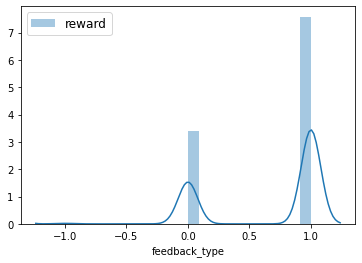

In [12]:

sns.distplot(behav_dat['feedback_type'],  kde=True, label='reward')

plt.legend(prop={'size': 12})

In [13]:
behav_dat['overall_accuracy'] = behav_dat.groupby(['session'])['accuracy'].transform(np.mean)



In [14]:
rp_means = behav_dat.groupby(['trial_type'])['response_time'].transform(np.mean)
pd.crosstab(rp_means, behav_dat['trial_type'])

trial_type,no_go,one_image,two_image_equal,two_image_unequal
response_time,,,,
1.207029,0,0,0,2744
1.269868,0,0,672,0
1.283974,0,3985,0,0
1.894070,2649,0,0,0


In [15]:
#contrast difference variable

behav_dat['contrast_diff'] = behav_dat["contrast_left"]-behav_dat["contrast_right"]
behav_dat.head()




,mouse_name,date_exp,contrast_right,contrast_left,response,response_time,feedback_type,gocue,feedback_time,trial_num,session,prev_reward,rew_hist_3,rew_hist_full,trial_type,accuracy,overall_accuracy,contrast_diff
0,Cori,2016-12-14,0.0,1.0,1.0,1.150204,1.0,1.027216,1.474423,0.0,0.0,0.0,0.0,0.0,one_image,1,0.686916,1.0
1,Cori,2016-12-14,0.5,0.0,-1.0,1.399503,1.0,0.874414,1.474423,1.0,0.0,1.0,0.0,1.0,one_image,1,0.686916,-0.5
2,Cori,2016-12-14,0.5,1.0,1.0,0.949291,1.0,0.825213,1.474423,2.0,0.0,1.0,0.0,1.0,two_image_unequal,1,0.686916,0.5
3,Cori,2016-12-14,0.0,0.0,0.0,2.266802,1.0,0.761612,1.474423,3.0,0.0,1.0,1.0,1.0,no_go,1,0.686916,0.0
4,Cori,2016-12-14,1.0,0.5,1.0,0.816776,0.0,0.662010,1.474423,4.0,0.0,1.0,1.0,1.0,two_image_unequal,0,0.686916,-0.5


In [16]:
pd.crosstab(behav_dat['feedback_type'], behav_dat['accuracy'])  #ok I mean it  looks like I sorted this correctly but it's really a pretty low accuracy overall



accuracy,0,1
feedback_type,,
-1.0,38,0
0.0,2826,263
1.0,0,6923


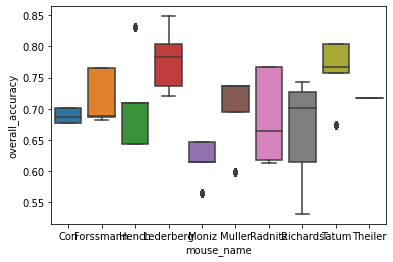

In [17]:
# choice bias variable

ax = sns.boxplot(x="mouse_name", y="overall_accuracy", data=behav_dat)



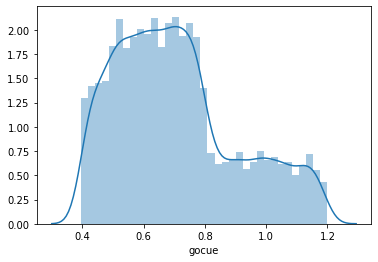

In [ ]:
sns.distplot(behav_dat.gocue)

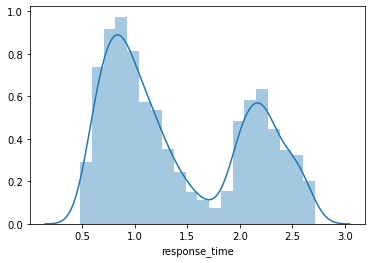

In [ ]:
sns.distplot(behav_dat.response_time)

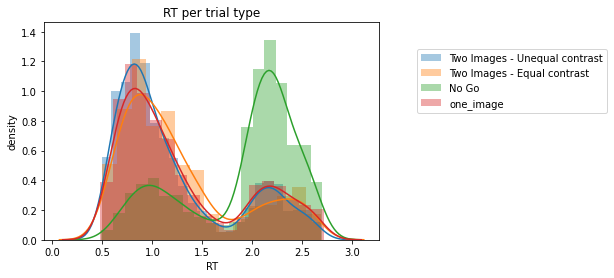

In [18]:
df1 = behav_dat[behav_dat.trial_type == "two_image_unequal"]
sns.distplot(df1['response_time'],  kde=True, label='Two Images - Unequal contrast')

df1= behav_dat[behav_dat.trial_type == 'two_image_equal']
sns.distplot(df1['response_time'],  kde=True, label='Two Images - Equal contrast')

df1= behav_dat[behav_dat.trial_type == 'no_go']
sns.distplot(df1['response_time'],  kde=True, label='No Go')

df1= behav_dat[behav_dat.trial_type == 'one_image']
sns.distplot(df1['response_time'],  kde=True, label='one_image')

plt.legend(prop={'size': 12})
plt.title('RT per trial type')
plt.xlabel('RT')
plt.ylabel('density')
plt.legend(bbox_to_anchor=[1.1, 0.9])




Text(0, 0.5, 'Density')

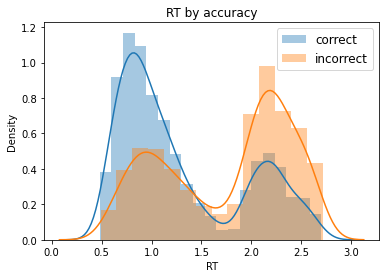

In [19]:
df4 = behav_dat[behav_dat.accuracy == 1]
sns.distplot(df4['response_time'],  kde=True, label='correct')

df4= behav_dat[behav_dat.accuracy == 0]
sns.distplot(df4['response_time'],  kde=True, label='incorrect')

plt.legend(prop={'size': 12})
plt.title('RT by accuracy')
plt.xlabel('RT')
plt.ylabel('Density')


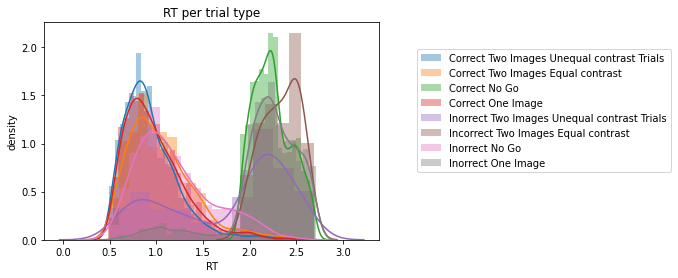

In [20]:
df1 = behav_dat[behav_dat.trial_type == "two_image_unequal" ]
df2=df1[df1.accuracy== 1]
sns.distplot(df2['response_time'],  kde=True, label='Correct Two Images Unequal contrast Trials')

df1= behav_dat[behav_dat.trial_type == "two_image_equal"]
df2=df1[df1.accuracy== 1]
sns.distplot(df2['response_time'],  kde=True, label='Correct Two Images Equal contrast')

df1= behav_dat[behav_dat.trial_type == 'no_go']
df2=df1[df1.accuracy== 1]
sns.distplot(df2['response_time'],  kde=True, label='Correct No Go')

df1= behav_dat[behav_dat.trial_type == 'one_image']
df2=df1[df1.accuracy== 1]
sns.distplot(df2['response_time'],  kde=True, label='Correct One Image')

df1 = behav_dat[behav_dat.trial_type == "two_image_unequal" ]
df2=df1[df1.accuracy== 0]
sns.distplot(df2['response_time'],  kde=True, label='Inorrect Two Images Unequal contrast Trials')

df1= behav_dat[behav_dat.trial_type == "two_image_equal"]
df2=df1[df1.accuracy== 0]
sns.distplot(df2['response_time'],  kde=True, label='Incorrect Two Images Equal contrast')

df1= behav_dat[behav_dat.trial_type == 'no_go']
df2=df1[df1.accuracy== 0]
sns.distplot(df2['response_time'],  kde=True, label='Inorrect No Go')

df1= behav_dat[behav_dat.trial_type == 'one_image']
df2=df1[df1.accuracy== 0]
sns.distplot(df2['response_time'],  kde=True, label='Inorrect One Image')

plt.legend(prop={'size': 12})
plt.title('RT per trial type')
plt.xlabel('RT')
plt.ylabel('density')
plt.legend(bbox_to_anchor=[1.1, 0.9])


In [22]:
#saving data
#drive.mount('/content/drive')
outfile=open("drive/My Drive/Colab Notebooks/NMA_proj/behav_dat.p","wb")
pickle.dump(behav_dat,outfile)
outfile.close()

# Trying DDM

In [23]:

import hddm

/usr/local/lib/python3.6/dist-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


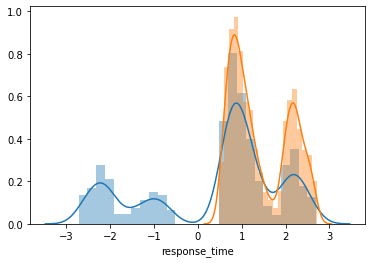

In [24]:
#what variables will I use for this
# response time, trial_num, session, subject, average reward history, trial type, previous reward
# I'd love to add maybe some kind of LFP from a region of interest and punishment history
#actually makes sense that we can't include session, subject, and trial number, since they kind of correlate
#I kept mouse name in th eend, but maybe session was better?


#ok check if 1) RT was done correctly. 2) look into how stim is coded (http://ski.clps.brown.edu/hddm_docs/howto.html#code-subject-responses)
# 3) figure out what each parameter means 4) select between accuracy and choice

def rt_flip(s):
    if (s['accuracy']==0):
        return -1*s['response_time']
    else:
      return s['response_time']

behav_dat['rt'] = behav_dat.apply(rt_flip, axis=1)


#behav_dat_ddm= behav_dat[["mouse_name", "trial_type","contrast_diff", "rew_hist_full", "rt"]]
#behav_dat_ddm= behav_dat[["mouse_name", "trial_type","accuracy", "rew_hist_full", "rt"]]
behav_dat_ddm1= behav_dat[["mouse_name", "trial_type","accuracy", "rt"]]
#renaming the columns
behav_dat_ddm1=behav_dat_ddm1.rename(columns={'mouse_name': 'subj_idx'})
behav_dat_ddm1=behav_dat_ddm1.rename(columns={'trial_type': 'stim'})
behav_dat_ddm1=behav_dat_ddm1.rename(columns={'accuracy': 'response'})

sns.distplot(behav_dat_ddm1['rt'], kde=True, label='Transformed if Incorrrect')
sns.distplot(behav_dat['response_time'],  kde=True, label='Original')


In [25]:
# Instantiate model object passing it our data (no need to call flip_errors() before passing it).
# This will tailor an individual hierarchical DDM around your dataset.
m = hddm.HDDM(behav_dat_ddm1)
# find a good starting point which helps with the convergence.
m.find_starting_values()
# start drawing 7000 samples and discarding 5000 as burn-in
m.sample(2000, burn=20)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2000 of 2000 complete in 306.4 sec

Plotting a
Plotting a_std
Plotting v
Plotting t


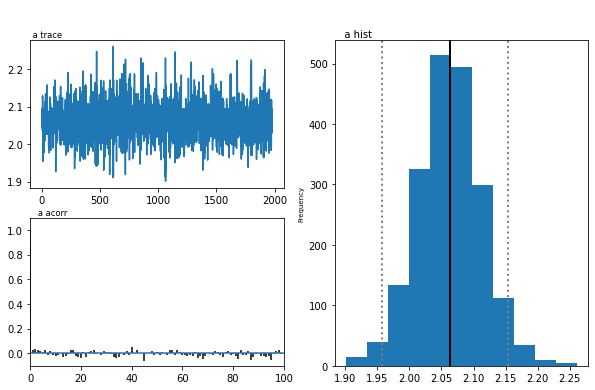

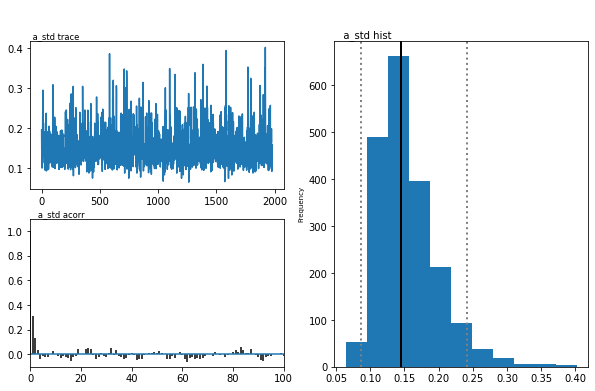

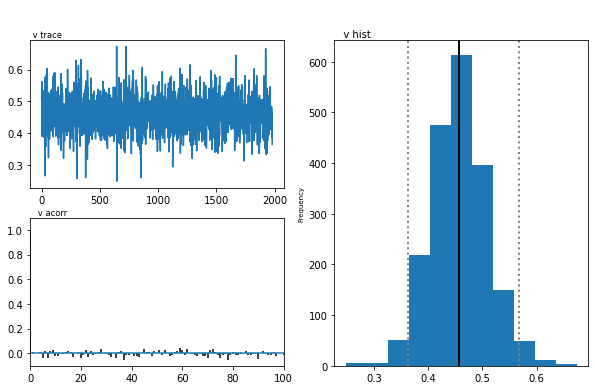

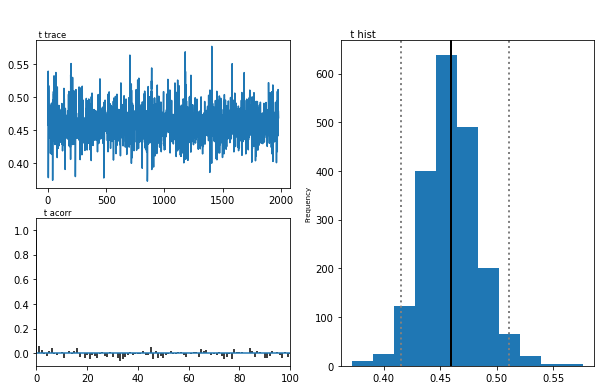

In [26]:
m.plot_posteriors(['a', 't', 'v', 'a_std'])

In [27]:
#saving first model
outfile=open("drive/My Drive/Colab Notebooks/NMA_proj/m.p","wb")
pickle.dump(m,outfile)
outfile.close()


ValueError: ignored

In [29]:
stats = m.gen_stats()
stats[stats.index.isin(['a', 'a_std', 'a_subj.Muller', 'a_subj.Lederberg'])]


outfile=open("drive/My Drive/Colab Notebooks/NMA_proj/m_stats.p","wb")
pickle.dump(stats,outfile)
outfile.close()


In [ ]:
stats[stats.index.isin(['v', 'v_std', 'v_subj.Muller', 'v_subj.Lederberg'])]

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
v,0.0892709,0.481025,-0.865298,-0.216656,0.0859508,0.376493,1.06385,0.0116087
v_std,1.51718,0.400207,0.967326,1.23133,1.45308,1.72061,2.49846,0.0137682
v_subj.Lederberg,-0.823911,0.033238,-0.890266,-0.845026,-0.823912,-0.800949,-0.760543,0.000710503
v_subj.Muller,-0.36315,0.0367613,-0.431368,-0.388519,-0.36364,-0.338661,-0.288786,0.000788447


In [30]:
models = []
for i in range(5):
    m = hddm.HDDM(behav_dat_ddm1)
    m.find_starting_values()
    m.sample(5000, burn=20)
    models.append(m)

hddm.analyze.gelman_rubin(models)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 5000 of 5000 complete in 759.6 sec

{'a': 0.9999914362244927,
 'a_std': 1.0001954170957437,
 'a_subj.Cori': 0.9999775446246768,
 'a_subj.Forssmann': 0.9999856037507597,
 'a_subj.Hench': 1.0003489693752428,
 'a_subj.Lederberg': 1.000135044531444,
 'a_subj.Moniz': 0.999932748732351,
 'a_subj.Muller': 0.9999523664216596,
 'a_subj.Radnitz': 0.9999981797933366,
 'a_subj.Richards': 1.0003672560975707,
 'a_subj.Tatum': 1.0001254636194392,
 'a_subj.Theiler': 1.000111742386391,
 't': 1.0000699114443548,
 't_std': 1.000302384926701,
 't_subj.Cori': 1.0000014827475199,
 't_subj.Forssmann': 0.9999112656364768,
 't_subj.Hench': 1.0003504676612478,
 't_subj.Lederberg': 1.0000462330631432,
 't_subj.Moniz': 1.0000412565527015,
 't_subj.Muller': 1.0001502353655836,
 't_subj.Radnitz': 1.0000721643177803,
 't_subj.Richards': 1.0005295990282308,
 't_subj.Tatum': 1.0003307167274744,
 't_subj.Theiler': 1.0001266724599904,
 'v': 1.0003107162352411,
 'v_std': 1.0007348953233615,
 'v_subj.Cori': 1.000028861972713,
 'v_subj.Forssmann': 0.99995153

In [33]:
m_convergence=hddm.analyze.gelman_rubin(models)
print (m_convergence)

outfile=open("drive/My Drive/Colab Notebooks/NMA_proj/m_convergence.p","wb")
pickle.dump(m_convergence,outfile)
outfile.close()
# values should be close to 1 and no larger than 1.2
#otherwise there is a convergence problem

{'a': 0.9999914362244927, 'a_std': 1.0001954170957437, 'a_subj.Cori': 0.9999775446246768, 'a_subj.Forssmann': 0.9999856037507597, 'a_subj.Hench': 1.0003489693752428, 'a_subj.Lederberg': 1.000135044531444, 'a_subj.Moniz': 0.999932748732351, 'a_subj.Muller': 0.9999523664216596, 'a_subj.Radnitz': 0.9999981797933366, 'a_subj.Richards': 1.0003672560975707, 'a_subj.Tatum': 1.0001254636194392, 'a_subj.Theiler': 1.000111742386391, 'v': 1.0003107162352411, 'v_std': 1.0007348953233615, 'v_subj.Cori': 1.000028861972713, 'v_subj.Forssmann': 0.9999515395483847, 'v_subj.Hench': 1.0002078838737765, 'v_subj.Lederberg': 0.9999930877214336, 'v_subj.Moniz': 1.0001180762115836, 'v_subj.Muller': 0.9999126279472945, 'v_subj.Radnitz': 1.0003949813729294, 'v_subj.Richards': 0.9999525168451172, 'v_subj.Tatum': 1.000052579278513, 'v_subj.Theiler': 1.0000844645056017, 't': 1.0000699114443548, 't_std': 1.000302384926701, 't_subj.Cori': 1.0000014827475199, 't_subj.Forssmann': 0.9999112656364768, 't_subj.Hench': 1.

# DDM part 2

We are going to adjust our question a bit. I'm specifically interested in how the contrast levels affect decision threshold. That is, if the contrasts are closer to each other, the decision will be harder and increase the decision threshold. Maybe this would be modulated by ACC activity (and hopefully we have something like that in the rodent LFP).

Both No-go and equal contrast trials both have contrast difference of 0, but signify totally different behavior and trial types. We're going to remove the two equal image trials, because in this type of trial you could respond in either direction and either was considered correct, but sometimes the reward wasn't given. We're also going to stick with the original contrast difference scores (not absolute value).

Next, I'll add reward history. Then I'll create punishment history.

In [34]:
# preparing the data

#a = behav_dat['contrast_diff']
#behav_dat['abs_contrast_diff'] =a.abs()

#def gm(s):
#    if (s['trial_type']=='no_go'):
#        return "inhibition"
#    else:
#      return "invigoration"

#behav_dat['invigoration'] = behav_dat.apply(gm, axis=1)

behav_dat_sub = behav_dat[behav_dat.trial_type != "two_image_equal" ]

behav_dat_ddm2= behav_dat_sub[["mouse_name", "contrast_diff","accuracy", "response_time"]]
behav_dat_ddm2=behav_dat_ddm2.rename(columns={'mouse_name': 'subj_idx'})
behav_dat_ddm2=behav_dat_ddm2.rename(columns={'contrast_diff': 'stim'})
behav_dat_ddm2=behav_dat_ddm2.rename(columns={'accuracy': 'response'})
behav_dat_ddm2=behav_dat_ddm2.rename(columns={'response_time': 'rt'})

behav_dat_ddm2 = hddm.utils.flip_errors(behav_dat_ddm2)

outfile=open("drive/My Drive/Colab Notebooks/NMA_proj/behav_dat_ddm2.p","wb")
pickle.dump(behav_dat_ddm2,outfile)
outfile.close()

behav_dat_ddm2.head()

,subj_idx,stim,response,rt
0,Cori,1.0,1,1.150204
1,Cori,-0.5,1,1.399503
2,Cori,0.5,1,0.949291
3,Cori,0.0,1,2.266802
4,Cori,-0.5,0,-0.816776


In [35]:
# Instantiate model object passing it our data (no need to call flip_errors() before passing it).
# This will tailor an individual hierarchical DDM around your dataset.
m2 = hddm.HDDM(behav_dat_ddm2)
# find a good starting point which helps with the convergence.
m2.find_starting_values()
# start drawing 7000 samples and discarding 5000 as burn-in
m2.sample(2000, burn=20)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2001 of 2000 complete in 291.5 sec

Plotting a
Plotting a_std
Plotting v
Plotting t


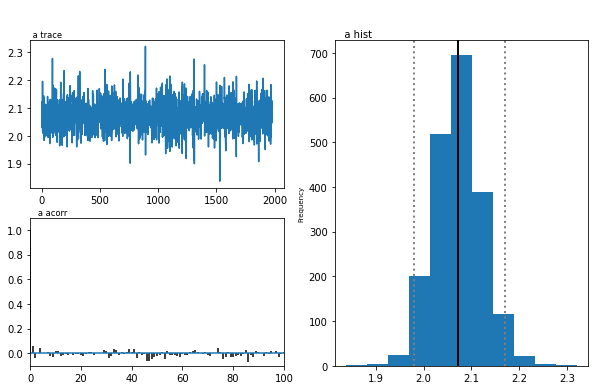

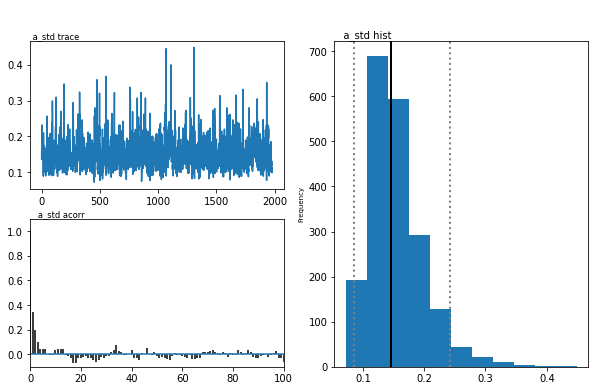

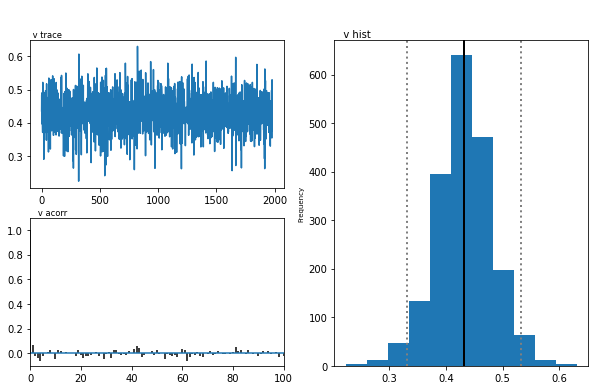

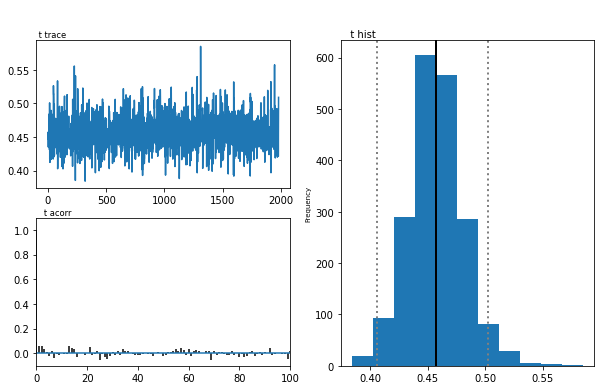

In [36]:
m2.plot_posteriors(['a', 't', 'v', 'a_std'])

In [39]:
stats_m2 = m2.gen_stats()
stats_m2[stats.index.isin(['a', 'a_std', 'a_subj.Muller', 'a_subj.Lederberg'])]


,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,2.0727,0.0503099,1.98087,2.04063,2.07108,2.10345,2.17359,0.00113854
a_std,0.154307,0.0450837,0.0926848,0.123598,0.145356,0.176048,0.265339,0.00161781
a_subj.Lederberg,1.79515,0.0214346,1.75304,1.7807,1.79484,1.80989,1.83661,0.000810385
a_subj.Muller,2.15889,0.0385649,2.08476,2.13335,2.15829,2.18358,2.23611,0.0010557


In [ ]:
outfile=open("drive/My Drive/Colab Notebooks/NMA_proj/m2_stats.p","wb")
pickle.dump(stats_m2,outfile)
outfile.close()

In [41]:
#### ok now the same model but with reward history added
behav_dat_ddm3= behav_dat_sub[["mouse_name", "contrast_diff","accuracy", "response_time", "rew_hist_full"]]
behav_dat_ddm3=behav_dat_ddm3.rename(columns={'mouse_name': 'subj_idx'})
behav_dat_ddm3=behav_dat_ddm3.rename(columns={'contrast_diff': 'stim'})
behav_dat_ddm3=behav_dat_ddm3.rename(columns={'accuracy': 'response'})
behav_dat_ddm3=behav_dat_ddm3.rename(columns={'response_time': 'rt'})

behav_dat_ddm3 = hddm.utils.flip_errors(behav_dat_ddm3)

outfile=open("drive/My Drive/Colab Notebooks/NMA_proj/behav_dat_ddm3.p","wb")
pickle.dump(behav_dat_ddm3,outfile)
outfile.close()

behav_dat_ddm3.head(20)

,subj_idx,stim,response,rt,rew_hist_full
0,Cori,1.00,1,1.150204,0.000000
1,Cori,-0.50,1,1.399503,1.000000
2,Cori,0.50,1,0.949291,1.000000
3,Cori,0.00,1,2.266802,1.000000
4,Cori,-0.50,0,-0.816776,1.000000
5,Cori,0.00,0,-1.517107,0.800000
6,Cori,0.00,0,-1.133210,0.666667
7,Cori,0.00,0,-1.349831,0.571429
8,Cori,0.00,1,2.097125,0.500000
9,Cori,0.50,1,1.249668,0.555556


In [42]:
# Instantiate model object passing it our data (no need to call flip_errors() before passing it).
# This will tailor an individual hierarchical DDM around your dataset.
m3 = hddm.HDDM(behav_dat_ddm3)
# find a good starting point which helps with the convergence.
m3.find_starting_values()
# start drawing 7000 samples and discarding 5000 as burn-in
m3.sample(2000, burn=20)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2000 of 2000 complete in 292.9 sec

Plotting a
Plotting a_std
Plotting v
Plotting t


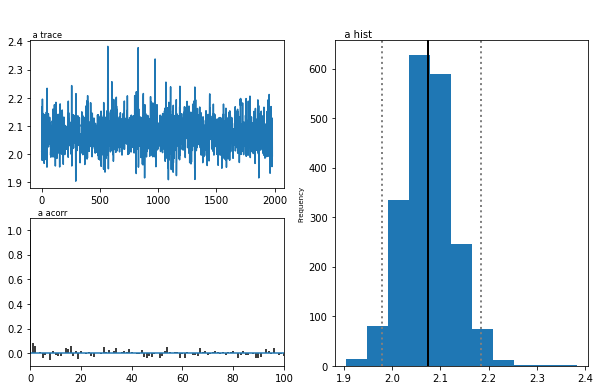

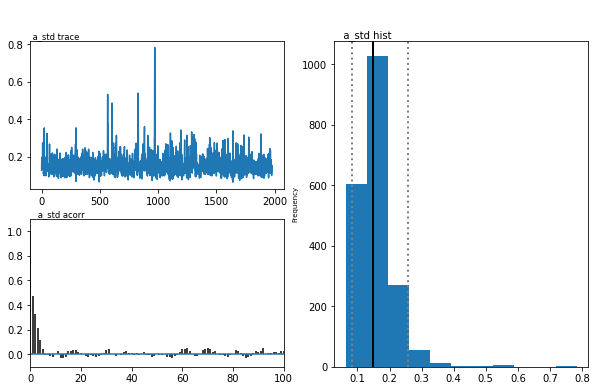

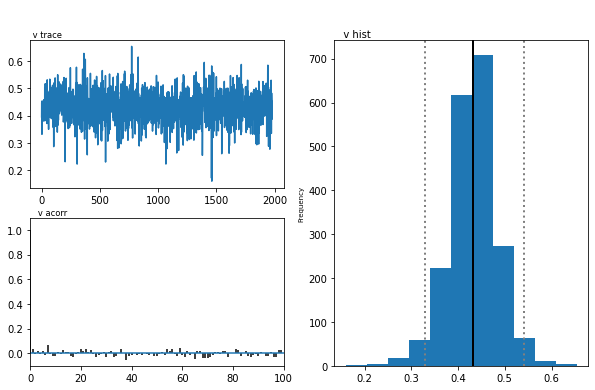

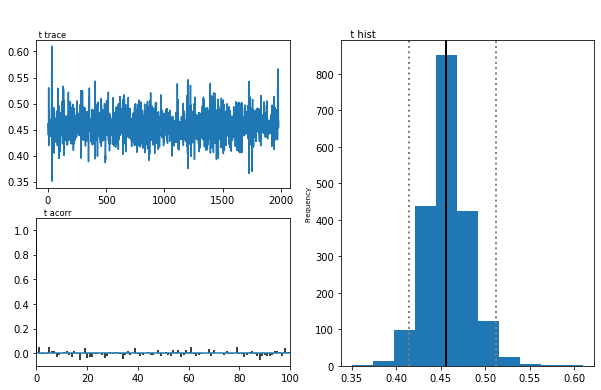

In [43]:
m3.plot_posteriors(['a', 't', 'v', 'a_std'])

In [44]:
stats_m3 = m3.gen_stats()
stats_m3

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,2.07494,0.0526894,1.97824,2.04062,2.07358,2.10674,2.18413,0.00124792
a_std,0.158189,0.0543611,0.0900566,0.123517,0.147691,0.179291,0.283171,0.00208787
a_subj.Cori,2.19159,0.0442947,2.10799,2.16083,2.19217,2.22095,2.27625,0.00156148
a_subj.Forssmann,2.11825,0.0321352,2.05668,2.09585,2.11774,2.13909,2.18216,0.000926447
a_subj.Hench,2.13304,0.0300934,2.07467,2.11319,2.13261,2.15352,2.19202,0.000971492
a_subj.Lederberg,1.79525,0.0215548,1.75536,1.78015,1.79485,1.81028,1.83734,0.000782785
a_subj.Moniz,2.20713,0.0464935,2.11839,2.1761,2.20578,2.23858,2.29879,0.00135263
a_subj.Muller,2.16289,0.0402445,2.08756,2.13484,2.16096,2.18901,2.24939,0.00112916
a_subj.Radnitz,2.12936,0.0357732,2.06117,2.10351,2.12951,2.15363,2.19921,0.00103668
a_subj.Richards,1.98273,0.0284145,1.92815,1.96386,1.98287,2.00096,2.03993,0.00101612


In [45]:
outfile=open("drive/My Drive/Colab Notebooks/NMA_proj/m3_stats.p","wb")
pickle.dump(stats_m3,outfile)
outfile.close()

In [46]:
models_m3 = []
for i in range(5):
    m3 = hddm.HDDM(behav_dat_ddm3)
    m3.find_starting_values()
    m3.sample(5000, burn=20)
    models3.append(m3)

hddm.analyze.gelman_rubin(models_m3)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 5000 of 5000 complete in 728.1 sec

IndexError: ignored

In [47]:
hddm.analyze.gelman_rubin(models)

{'a': 1.006895371167808,
 'a_std': 1.0002256731630519,
 'a_subj.Cori': 1.0031777898123575,
 'a_subj.Forssmann': 1.059859615221508,
 'a_subj.Hench': 1.0191291453055562,
 'a_subj.Lederberg': 1.0362530609804996,
 'a_subj.Moniz': 1.0051879609105898,
 'a_subj.Muller': 1.0103782215008343,
 'a_subj.Radnitz': 1.0174085993440158,
 'a_subj.Richards': 1.0493540739141742,
 'a_subj.Tatum': 1.0172508518735348,
 'a_subj.Theiler': 1.0001861284714968,
 't': 1.0020876128029332,
 't_std': 1.000964111912,
 't_subj.Cori': 1.0051944973310296,
 't_subj.Forssmann': 1.0469679411003179,
 't_subj.Hench': 1.0074935598572146,
 't_subj.Lederberg': 1.017208594587037,
 't_subj.Moniz': 1.0430528031375177,
 't_subj.Muller': 1.002157909518088,
 't_subj.Radnitz': 1.0031712286934358,
 't_subj.Richards': 1.0012230701498428,
 't_subj.Tatum': 1.0213608843708706,
 't_subj.Theiler': 1.0001118481373683,
 'v': 1.0353397313540529,
 'v_std': 1.001388704667351,
 'v_subj.Cori': 1.204909938858733,
 'v_subj.Forssmann': 1.1096440310887

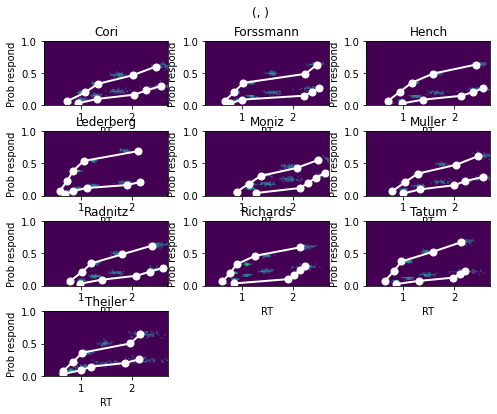

In [60]:
#plot posterior predictive
#can't seem to get teh actual posterior predictive plot to work but at least we have this
m3.plot_posterior_quantiles(save=True)


In [61]:
#@title Drift rate based on type of visual stimulus
#looking at within subject differences in drift rate based on trial type

m3_stim = hddm.HDDM(behav_dat_ddm3, depends_on={'v': 'stim'})
m3_stim.find_starting_values()
m3_stim.sample(10000, burn=1000)


/usr/local/lib/python3.6/dist-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 10001 of 10000 complete in 4919.3 sec

Plotting a
Plotting a_std
Plotting v(-1.0)
Plotting v(-0.75)
Plotting v(-0.5)
Plotting v(-0.25)
Plotting v(0.0)
Plotting v(0.25)
Plotting v(0.5)
Plotting v(0.75)
Plotting v(1.0)
Plotting t


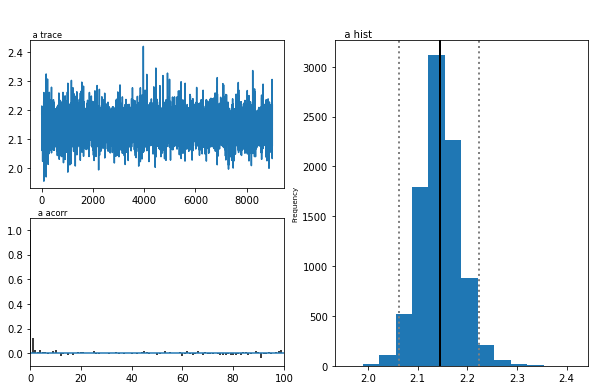

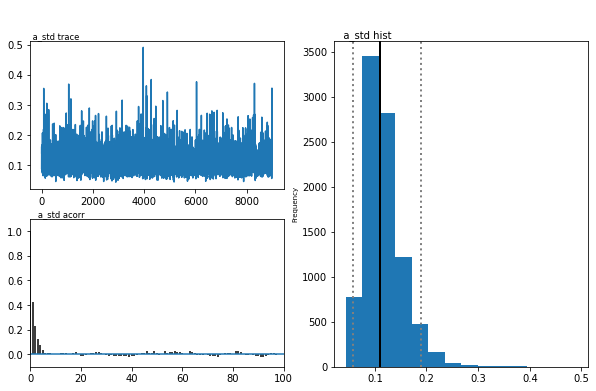

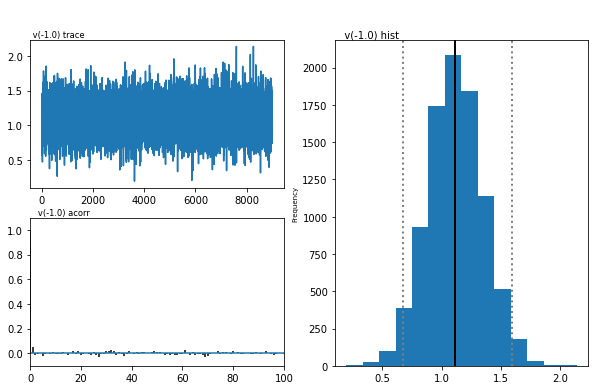

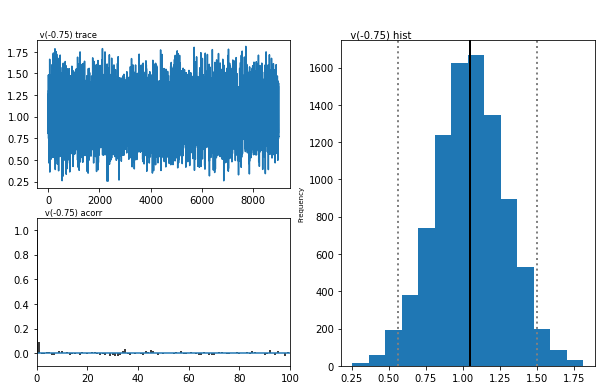

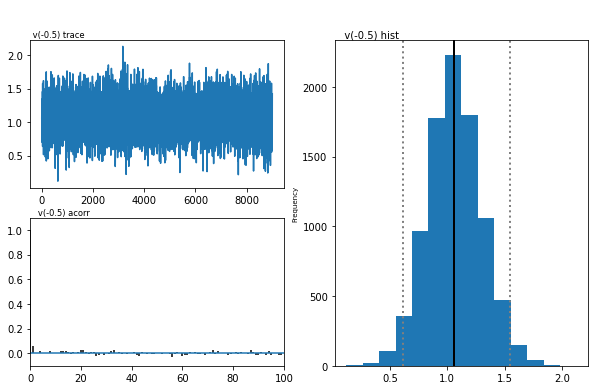

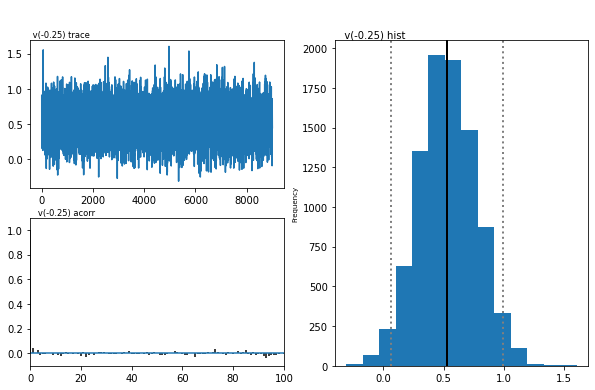

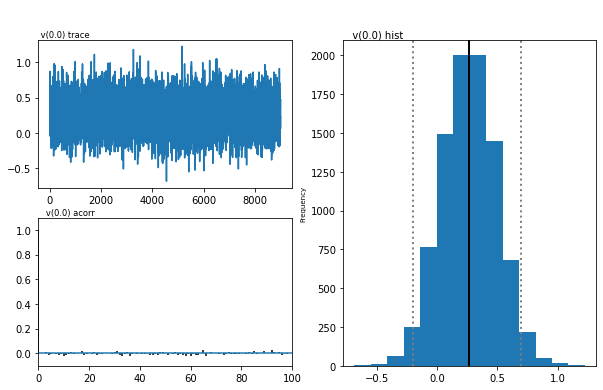

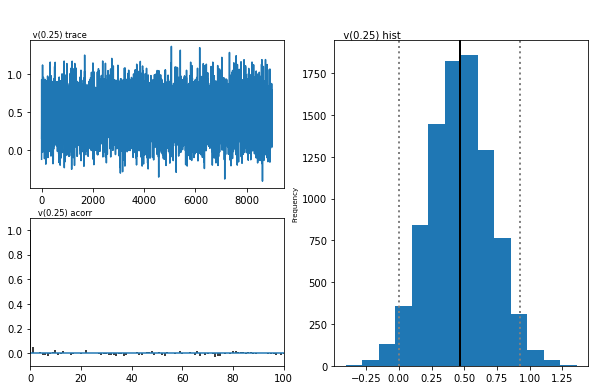

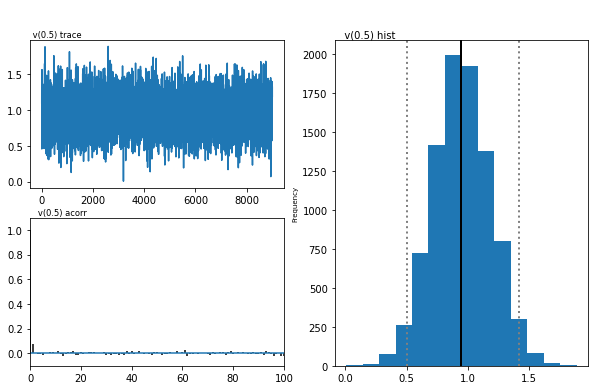

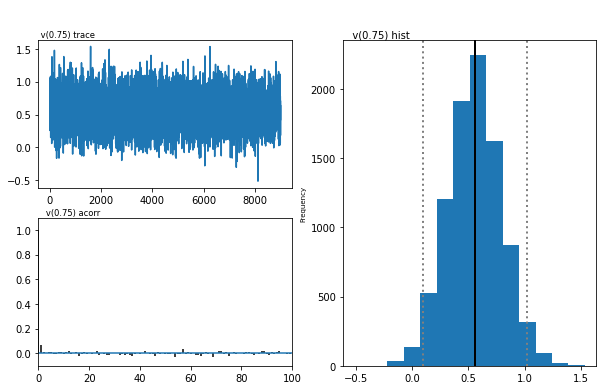

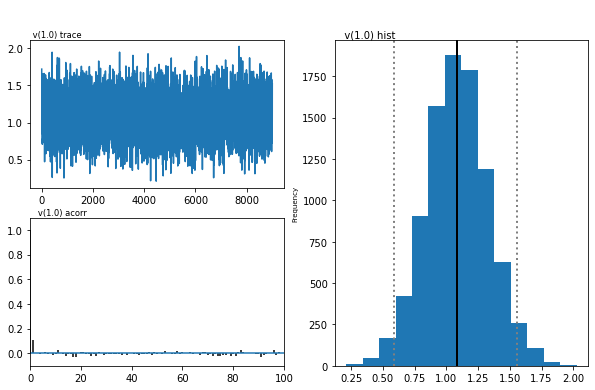

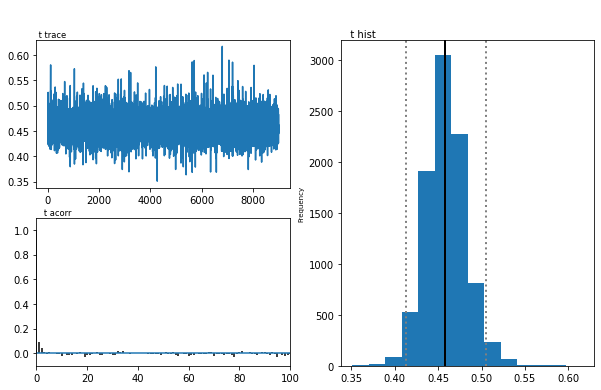

In [89]:
m3_stim.plot_posteriors(['a', 't', 'v', 'a_std'])

In [92]:
m3_stim_stats=m3_stim.gen_stats()
outfile=open("drive/My Drive/Colab Notebooks/NMA_proj/m3_stim_stats.p","wb")
pickle.dump(m3_stim_stats,outfile)
outfile.close()


In [88]:
#wasn't letting me pickle so I got stuck with this

m3_indexnames = m3_stim.nodes_db.index.values
m3_indexnames
m3_stim_regdf=pd.DataFrame(m3_stim.nodes_db)
m3_stim_regdf.shape
m3_stim_regdf.to_csv(index=True)




',knode_name,stochastic,observed,subj,node,tag,depends,hidden,subj_idx,stim,response,rt,rew_hist_full,mean,std,2.5q,25q,50q,75q,97.5q,mc err,map\na,a,True,False,False,a,(),[],False,,,,,,2.1447544996120813,0.040530421490029896,2.0657837973853974,2.1194771768829073,2.1440337343823628,2.1694353745490145,2.2271244604768237,0.0005299046016304523,2.1849086556489565\na_std,a_std,True,False,False,a_std,(),[],False,,,,,,0.11703381533767765,0.037508557168552496,0.0649890749167575,0.09143838605596072,0.1102432809715709,0.13486408725833932,0.20842720123717134,0.0006521227644166667,0.11971823907874925\na_rate,a_rate,False,False,False,a_rate,(),[],True,,,,,,,,,,,,,,152.44481047446249\na_shape,a_shape,False,False,False,a_shape,(),[],True,,,,,,,,,,,,,,333.07798591441775\na_subj.Cori,a_subj,True,False,True,a_subj.Cori,(),[\'subj_idx\'],False,Cori,,,,,2.2506497558294436,0.043883222231587714,2.1686333708749297,2.219687680572292,2.2494817031267043,2.2797510528642633,2.3395308495432414,0.000600560008033346

In [94]:
m3_indexnames

array(['a', 'a_std', 'a_rate', 'a_shape', 'a_subj.Cori',
       'a_subj.Forssmann', 'a_subj.Hench', 'a_subj.Lederberg',
       'a_subj.Moniz', 'a_subj.Muller', 'a_subj.Radnitz',
       'a_subj.Richards', 'a_subj.Tatum', 'a_subj.Theiler', 'v(-1.0)',
       'v(-0.75)', 'v(-0.5)', 'v(-0.25)', 'v(0.0)', 'v(0.25)', 'v(0.5)',
       'v(0.75)', 'v(1.0)', 'v_std', 'v_tau', 'v_subj(-1.0).Cori',
       'v_subj(-1.0).Forssmann', 'v_subj(-1.0).Hench',
       'v_subj(-1.0).Lederberg', 'v_subj(-1.0).Moniz',
       'v_subj(-1.0).Muller', 'v_subj(-1.0).Radnitz',
       'v_subj(-1.0).Richards', 'v_subj(-1.0).Tatum',
       'v_subj(-1.0).Theiler', 'v_subj(-0.75).Cori',
       'v_subj(-0.75).Forssmann', 'v_subj(-0.75).Hench',
       'v_subj(-0.75).Lederberg', 'v_subj(-0.75).Moniz',
       'v_subj(-0.75).Muller', 'v_subj(-0.75).Radnitz',
       'v_subj(-0.75).Richards', 'v_subj(-0.75).Tatum',
       'v_subj(-0.75).Theiler', 'v_subj(-0.5).Cori',
       'v_subj(-0.5).Forssmann', 'v_subj(-0.5).Hench',
      

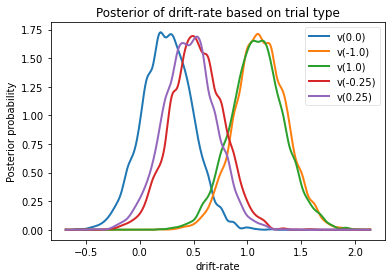

In [99]:
v_no_go, v_one_right, v_one_left, v_25_right, v_25_left= m3_stim.nodes_db.node[['v(0.0)', 'v(-1.0)', 'v(1.0)',"v(-0.25)", "v(0.25)"]]
v_50_right, v_50_left,v_75_right, v_75_left =m3_stim.nodes_db.node[["v(-0.5)", "v(0.5)","v(-0.75)", "v(0.75)"]]

hddm.analyze.plot_posterior_nodes([v_no_go, v_one_right, v_one_left, v_25_right, v_25_left])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate based on trial type')
plt.savefig('m3_stim_v_posteriors.png')


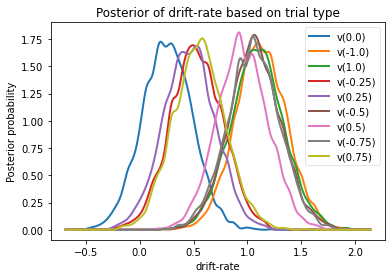

In [100]:

hddm.analyze.plot_posterior_nodes([v_no_go, v_one_right, v_one_left, v_25_right, v_25_left,v_50_right, v_50_left,v_75_right, v_75_left])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate based on trial type')
plt.savefig('m3_stim_v_posteriors_all.png')


In [ ]:
#now I want to check out the effect of reward history on drift rate?
m3_reg = hddm.HDDMRegressor(behav_dat_ddm3,
                           "a ~ theta:C(conf, Treatment('LC'))",
                           depends_on={'v': 'stim'})

In [64]:
stats_m3_stim = m3_stim.gen_stats()
stats_m3_stim

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,2.144754,0.040530,2.065784,2.119477,2.144034,2.169435,2.227124,0.000530
a_std,0.117034,0.037509,0.064989,0.091438,0.110243,0.134864,0.208427,0.000652
a_subj.Cori,2.250650,0.043883,2.168633,2.219688,2.249482,2.279751,2.339531,0.000601
a_subj.Forssmann,2.207025,0.037336,2.135480,2.181374,2.206457,2.231617,2.283662,0.000529
a_subj.Hench,2.153621,0.029569,2.097099,2.133532,2.153560,2.173466,2.213342,0.000457
...,...,...,...,...,...,...,...,...
t_subj.Muller,0.494740,0.010832,0.472352,0.487800,0.494992,0.502176,0.514972,0.000145
t_subj.Radnitz,0.499941,0.009888,0.480126,0.493434,0.500159,0.506653,0.518716,0.000150
t_subj.Richards,0.405149,0.008522,0.387970,0.399559,0.405261,0.411012,0.421286,0.000145
t_subj.Tatum,0.423970,0.009010,0.405485,0.418020,0.424319,0.430275,0.440698,0.000168


In [127]:
traces=m3_stim.get_traces()
#print(traces)
outfile=open("drive/My Drive/Colab Notebooks/NMA_proj/m3_stim_traces.p","wb")
pickle.dump(traces,outfile)
outfile.close()

outfile=open("drive/My Drive/Colab Notebooks/NMA_proj/traces/v_one_right_traces.p","wb")
pickle.dump(v_one_right.trace(),outfile)
outfile.close()
outfile=open("drive/My Drive/Colab Notebooks/NMA_proj/traces/v_one_left_traces.p","wb")
pickle.dump(v_one_left.trace(),outfile)
outfile.close()

outfile=open("drive/My Drive/Colab Notebooks/NMA_proj/traces/v_nogo_traces.p","wb")
pickle.dump(v_no_go.trace(),outfile)
outfile.close()
outfile=open("drive/My Drive/Colab Notebooks/NMA_proj/traces/v_50_right_traces.p","wb")
pickle.dump(v_50_right.trace(),outfile)
outfile.close()
outfile=open("drive/My Drive/Colab Notebooks/NMA_proj/traces/v_50_left_traces.p","wb")
pickle.dump(v_50_left.trace(),outfile)
outfile.close()
outfile=open("drive/My Drive/Colab Notebooks/NMA_proj/traces/v_75_right_traces.p","wb")
pickle.dump(v_75_right.trace(),outfile)
outfile.close()
outfile=open("drive/My Drive/Colab Notebooks/NMA_proj/traces/v_75_right_left.p","wb")
pickle.dump(v_75_left.trace(),outfile)
outfile.close()
outfile=open("drive/My Drive/Colab Notebooks/NMA_proj/traces/v_25_right_traces.p","wb")
pickle.dump(v_25_right.trace(),outfile)
outfile.close()
outfile=open("drive/My Drive/Colab Notebooks/NMA_proj/traces/v_25_right_left.p","wb")
pickle.dump(v_25_left.trace(),outfile)
outfile.close()
#list(traces.columns.values.tolist()) 

0.26463808140277173

In [120]:
#hypothesis testing

print("P(One image (right) < No-go) = ", (v_one_right.trace() < v_no_go.trace()).mean())
print("P(One image (left) < No-go) = ", (v_one_left.trace() <v_no_go.trace()).mean())


print("P(One image (right) < No-go) = ", (v_one_right.trace() < v_no_go.trace()).mean())
print("P(One image (left) < No-go) = ", (v_one_left.trace() <v_no_go.trace()).mean())



P(One image (right) < No-go) =  0.005111111111111111
P(One image (left) < No-go) =  0.006666666666666667


# DDM part 3 - Inhibition vs Invigoration
Would be awesome to see if drift rates are different in go/no-go trials and if neurons in the SN/VTA modulate that relationship